# Simple inference example with CroCo-Stereo or CroCo-Flow

In [1]:
# Copyright (C) 2022-present Naver Corporation. All rights reserved.
# Licensed under CC BY-NC-SA 4.0 (non-commercial use only).

First download the model(s) of your choice by running
```bash
CROCO_ROOT_DPATH=$(git rev-parse --show-toplevel)
CROCO_STEREOFLOW_BASE_URL='https://download.europe.naverlabs.com/ComputerVision/CroCo/StereoFlow_models'
wget "${CROCO_STEREOFLOW_BASE_URL}/crocostereo.pth" -P "${CROCO_ROOT_DPATH}/checkpoints/"
wget "${CROCO_STEREOFLOW_BASE_URL}/crocoflow.pth" -P "${CROCO_ROOT_DPATH}/checkpoints/"
```

In [1]:
import torch
import matplotlib.pylab as plt

use_gpu = torch.cuda.is_available() and torch.cuda.device_count()>0
device = torch.device('cuda:0' if use_gpu else 'cpu')

In [2]:
from pathlib import Path
from croco.stereoflow.test import _load_model_and_criterion
from croco.stereoflow.engine import tiled_pred
from croco.stereoflow.datasets_stereo import img_to_tensor, vis_disparity
from croco.stereoflow.datasets_flow import flowToColor

import numpy as np
from PIL import Image

tile_overlap=0.7 # recommended value, higher value can be slightly better but slower
this_dpath = Path().resolve()
assert (this_dpath / "croco-stereo-flow-demo.ipynb").is_file()

### CroCo-Stereo example

In [4]:
image1 = np.asarray(Image.open(this_dpath / '../assets/stereo_middlebury_0.png'))
image2 = np.asarray(Image.open(this_dpath / '../assets/stereo_middlebury_1.png'))

In [5]:
model, _, cropsize, with_conf, task, tile_conf_mode = _load_model_and_criterion(this_dpath / '../checkpoints/crocostereo.pth', None, device)

loading model from /home/sam/Safe/Proj/Number/0041_Volumetric-flow-estimation/POC1/croco/demo/../checkpoints/crocostereo.pth
head: PixelwiseTaskWithDPT()
croco_args: {'enc_embed_dim': 1024, 'enc_depth': 24, 'enc_num_heads': 16, 'dec_embed_dim': 768, 'dec_num_heads': 12, 'dec_depth': 12, 'img_size': (352, 704), 'pos_embed': 'RoPE100'}
  PixelwiseTaskWithDPT: automatically setting hook_idxs=[23, 27, 31, 35]
<All keys matched successfully>


In [6]:
im1 = img_to_tensor(image1).to(device).unsqueeze(0)
im2 = img_to_tensor(image2).to(device).unsqueeze(0)
with torch.inference_mode():
    pred, _, _ = tiled_pred(model, None, im1, im2, None, conf_mode=tile_conf_mode, overlap=tile_overlap, crop=cropsize, with_conf=with_conf, return_time=False)
pred = pred.squeeze(0).squeeze(0).cpu().numpy()

/home/sam/Safe/Proj/Number/0041_Volumetric-flow-estimation/POC1/croco/croco/stereoflow/datasets_stereo.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.


(-0.5, 2839.5, 1983.5, -0.5)

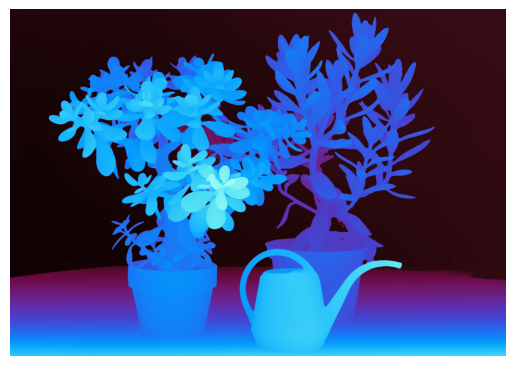

In [7]:
plt.imshow(vis_disparity(pred))
plt.axis('off')

### CroCo-Flow example

In [3]:
image1 = np.asarray(Image.open(this_dpath / '../assets/flow_davis_00000.jpg'))
image2 = np.asarray(Image.open(this_dpath / '../assets/flow_davis_00001.jpg'))

In [4]:
model, _, cropsize, with_conf, task, tile_conf_mode = _load_model_and_criterion(this_dpath / '../checkpoints/crocoflow.pth', None, device)

loading model from /home/sam/Safe/Proj/Number/0041_Volumetric-flow-estimation/POC1/croco/demo/../checkpoints/crocoflow.pth
head: PixelwiseTaskWithDPT()
croco_args: {'enc_embed_dim': 1024, 'enc_depth': 24, 'enc_num_heads': 16, 'dec_embed_dim': 768, 'dec_num_heads': 12, 'dec_depth': 12, 'img_size': (320, 384), 'pos_embed': 'RoPE100'}
  PixelwiseTaskWithDPT: automatically setting hook_idxs=[23, 27, 31, 35]
<All keys matched successfully>


In [5]:
im1 = img_to_tensor(image1).to(device).unsqueeze(0)
im2 = img_to_tensor(image2).to(device).unsqueeze(0)
with torch.inference_mode():
    pred, _, _ = tiled_pred(model, None, im1, im2, None, conf_mode=tile_conf_mode, overlap=tile_overlap, crop=cropsize, with_conf=with_conf, return_time=False)
pred = pred.squeeze(0).permute(1,2,0).cpu().numpy()

/home/sam/Safe/Proj/Number/0041_Volumetric-flow-estimation/POC1/croco/croco/stereoflow/datasets_stereo.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.


(-0.5, 853.5, 479.5, -0.5)

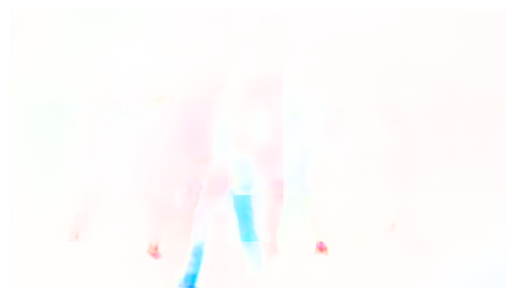

In [6]:
plt.imshow(flowToColor(pred))
plt.axis('off')